In [53]:
# Jupyter notebook: optional formatting extension
# %load_ext nb_black

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import os
import datetime
import math
from math import ceil

# Preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor

# Clustering evaluation
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Stats
from scipy.stats import chi2_contingency, stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.mosaicplot import mosaic

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Model selection
from sklearn.model_selection import GridSearchCV

# Geospatial
#from geopy.geocoders import Nominatim
#from geopy.distance import geodesic
#import geopandas as gpd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mpl_colors
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import plotly.express as px
import matplotlib.cm as cm

# DBSCAN
from collections import Counter

# SOM 
from minisom import MiniSom

In [15]:
df_behavioral = pd.read_csv("df_ready_for_clustering.csv")
df_behavioral.head()

,PointsRedeemedRatio,FlightsWithCompanionsRatio,AvgDistancePerFlight,KMPerRedeemedPoint,UnredeemedPoints,LoyaltyIndex,CustomerSegment,HasBonus,AvgMonthlyFlights,sr_jan,...,Education,Income,Marital Status,LoyaltyStatus,EnrollmentMonth,Time on Program,Cancelled,Reenroll,EnrollmentType,Customer Lifetime Value
0,0.387904,0.200000,2356.577778,25.786888,32446,709.589704,Moderate traveler and high redeemed,0,6.250000,0.026667,...,Bachelor,82877.0,Married,Aurora,8,874,N,0,Standard,7919.20
1,0.553363,0.224490,1384.141224,18.077435,15141,418.130598,Low traveler and low redeemed,0,6.805556,0.077551,...,College,0.0,Single,Nova,3,2122,N,0,Standard,2887.74
2,0.113362,0.241706,2047.539336,88.241585,38293,616.640254,Moderate traveler and low redeemed,0,5.861111,0.094787,...,College,0.0,Divorced,Nova,7,884,N,0,Standard,2838.07
3,0.354092,0.157407,3375.941667,28.248369,23544,1014.088728,High traveler and high redeemed,0,3.000000,0.000000,...,Bachelor,42837.0,Married,Star,8,1242,N,0,Standard,4170.57
4,0.253580,0.276243,2373.649171,39.448214,32058,714.181936,Moderate traveler and high redeemed,0,5.027778,0.022099,...,Bachelor,80979.0,Divorced,Star,1,1816,N,0,Standard,6622.05


In [16]:
df_behavioral.columns

Index(['PointsRedeemedRatio', 'FlightsWithCompanionsRatio',
       'AvgDistancePerFlight', 'KMPerRedeemedPoint', 'UnredeemedPoints',
       'LoyaltyIndex', 'CustomerSegment', 'HasBonus', 'AvgMonthlyFlights',
       'sr_jan', 'sr_feb', 'sr_mar', 'sr_apr', 'sr_may', 'sr_jun', 'sr_jul',
       'sr_aug', 'sr_sep', 'sr_oct', 'sr_nov', 'sr_dec', 'Province or State',
       'Education', 'Income', 'Marital Status', 'LoyaltyStatus',
       'EnrollmentMonth', 'Time on Program', 'Cancelled', 'Reenroll',
       'EnrollmentType', 'Customer Lifetime Value'],
      dtype='object')

In [17]:
behavioral_features = [

    'AvgMonthlyFlights',
    'AvgDistancePerFlight',
    'FlightsWithCompanionsRatio',
    'PointsRedeemedRatio',
]

df_behavioral = df_behavioral[behavioral_features]


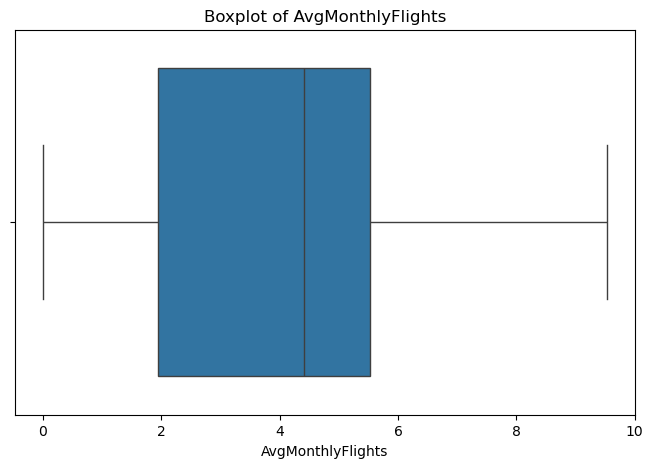

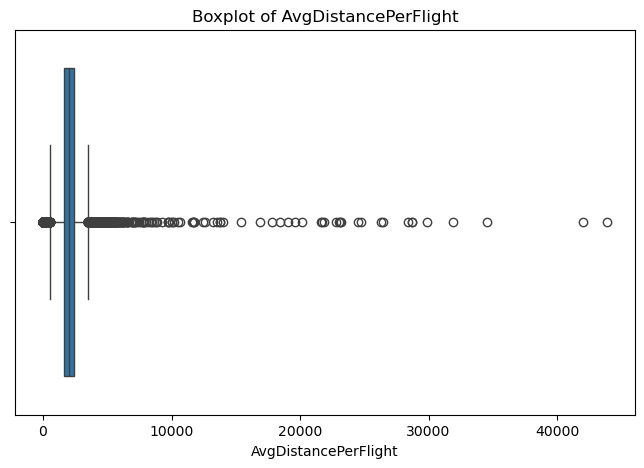

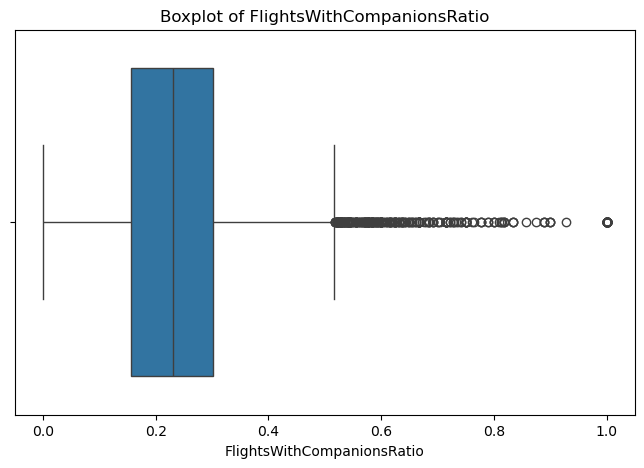

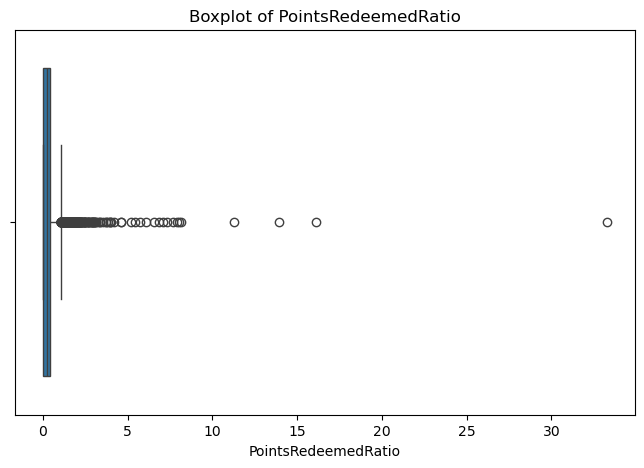

In [18]:
# I want to visualize the outliers in each column using boxplots
for column in df_behavioral.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df_behavioral[column])
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.show()

In [19]:
# Transform the features
scaler = StandardScaler()
df_behavioral_scaled = scaler.fit_transform(df_behavioral)  

df_scaled = pd.DataFrame(df_behavioral_scaled, columns=behavioral_features)

## Exploratory Data Analysis

In [20]:
def count_outliers_for_columns(df, column_names):
    """
    Count the number of outliers for each specified column in a DataFrame using the IQR method.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    column_names (list): A list of column names to analyze.

    Returns:
    list: A list of tuples where each tuple contains the column name and the number of outliers.
    """
    outliers_count_list = []

    for column_name in column_names:
        # Calculate Q1 (25th percentile) and Q3 (75th percentile)
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)

        # Calculate IQR (Interquartile Range)
        IQR = Q3 - Q1

        # Define outliers as values below Q1 - 1.5*IQR or above Q3 + 1.5*IQR
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count the outliers
        outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
        outlier_count = outliers.shape[0]

        # Append the result as a tuple (column_name, outlier_count)
        x = "{p}%".format(p = int(outlier_count/df.shape[0]*1000)/10)
        outliers_count_list.append((column_name, outlier_count,x))

    return outliers_count_list

# Assuming df is your DataFrame and you have a list of column names
outliers_counts = count_outliers_for_columns(df_behavioral, df_behavioral.columns)

for col in outliers_counts:
    print(col)

('AvgMonthlyFlights', 0, '0.0%')
('AvgDistancePerFlight', 2042, '12.3%')
('FlightsWithCompanionsRatio', 317, '1.9%')
('PointsRedeemedRatio', 408, '2.4%')


## Outliers

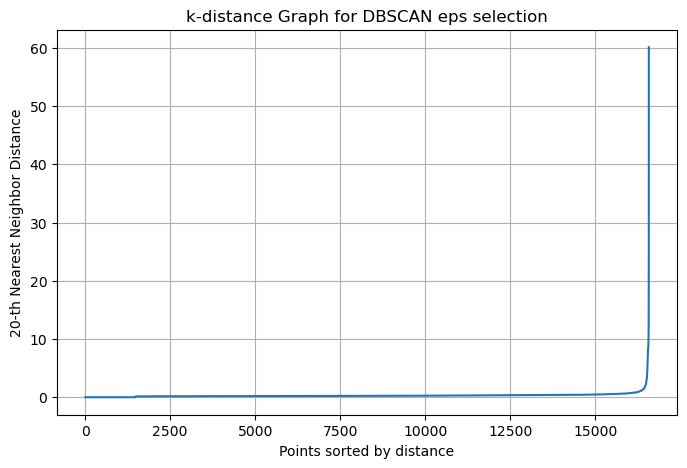

In [21]:
X = df_scaled.values  # DBSCAN input
min_samples = 20

# Compute nearest neighbors
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# Use distance to the kth neighbor
k_distances = np.sort(distances[:, -1])
plt.figure(figsize=(8,5))
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.title('k-distance Graph for DBSCAN eps selection')
plt.grid(True)
plt.show()

In [22]:
# Remove outliers using DBSCAN
dbscan = DBSCAN(eps=2.0, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df_scaled)

# Check outlier count
outlier_count = Counter(dbscan_labels)
print(f"DBSCAN results: {outlier_count}")
print(f"Outliers detected: {outlier_count[-1]}")
print(f"Core customers: {outlier_count[0]}")

# Save outliers for later classification
clean_mask = dbscan_labels != -1
df = df_behavioral[clean_mask].copy()
df_scaled_clean = df_scaled[clean_mask].copy()
df_out = df_behavioral[~clean_mask].copy()


print(f"\nWorking with {len(df):,} core customers")
print(f"Outliers saved for later: {len(df_out)}")

DBSCAN results: Counter({np.int64(0): 16509, np.int64(-1): 65})
Outliers detected: 65
Core customers: 16509

Working with 16,509 core customers
Outliers saved for later: 65


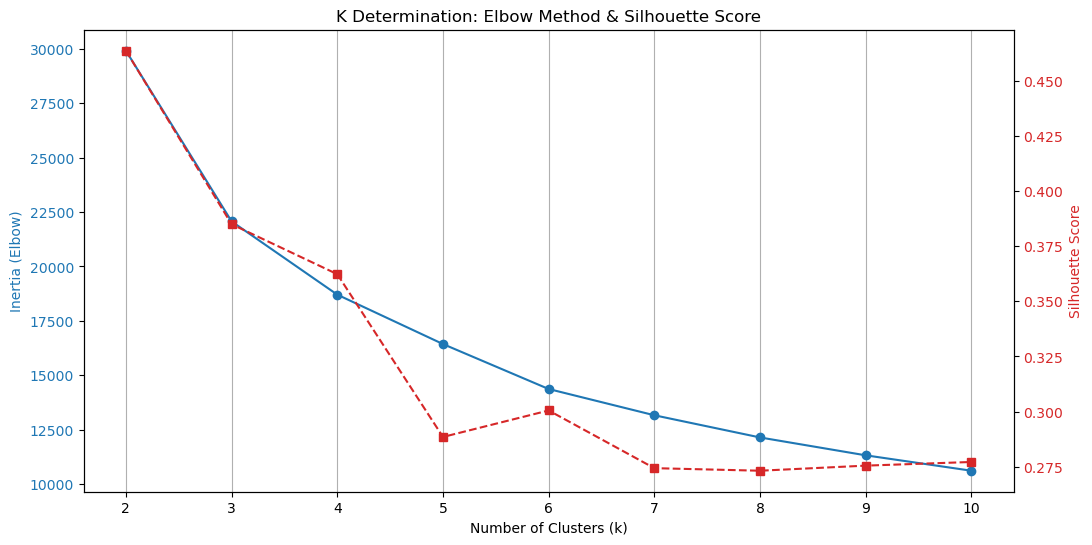

In [23]:
# K-means Otimization(Elbow & Silhouette)
inertia = []
silhouette = []
K_range = range(2, 11)  # Test 2 a 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled_clean)
    
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(df_scaled_clean, kmeans.labels_))

# Plots
fig, ax1 = plt.subplots(figsize=(12, 6))

# Elbow Plot - Blue Line
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Elbow)', color='tab:blue')
ax1.plot(K_range, inertia, marker='o', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, axis='x')

# Silhouette Plot - Red Line
ax2 = ax1.twinx()  
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(K_range, silhouette, marker='s', linestyle='--', color='tab:red', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('K Determination: Elbow Method & Silhouette Score')
plt.show()

# Hierarchical Clustering 

In [ ]:
def get_ss(df, feats):
    """Compute total sum of squares (SST) for features in df."""
    X = df[feats].values
    mean_vec = X.mean(axis=0)
    return ((X - mean_vec)**2).sum()

def get_ssw(df, feats, label_col):
    """Compute sum of squares within clusters (SSW)."""
    X = df[feats].values
    labels = df[label_col].values
    ssw = 0
    for lbl in np.unique(labels):
        cluster_points = X[labels == lbl]
        cluster_mean = cluster_points.mean(axis=0)
        ssw += ((cluster_points - cluster_mean)**2).sum()
    return ssw

def get_rsq(df, feats, label_col):
    """Compute R² for clustering solution."""
    sst = get_ss(df, feats)
    ssw = get_ssw(df, feats, label_col)
    ssb = sst - ssw
    return ssb / sst


def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """Compute R² for a range of cluster solutions."""
    r2 = []
    feats = df.columns.tolist()
    
    for i in range(min_nclus, max_nclus + 1):
        cluster = AgglomerativeClustering(
            n_clusters=i,
            metric=dist,
            linkage=link_method
        )
        hclabels = cluster.fit_predict(df[feats])
        df_concat = pd.concat([df, pd.Series(hclabels, name='labels', index=df.index)], axis=1)
        r2.append(get_rsq(df_concat, feats, 'labels'))
    
    return np.array(r2)


metric_features = df_scaled_clean.columns.tolist()  
hc_methods = ["ward", "complete", "average", "single"]
max_nclus = 10

results = []

for link in hc_methods:
    r2 = get_r2_hc(
        df=df[metric_features],
        link_method=link,
        max_nclus=max_nclus,
        min_nclus=1,
        dist="euclidean"
    )
    results.append(r2)

r2_hc = np.vstack(results)


sns.set(style="whitegrid")
plt.figure(figsize=(11,5))

for i, link in enumerate(hc_methods):
    plt.plot(range(1, max_nclus + 1), r2_hc[i], marker='o', linewidth=2.5, label=link)

plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("$R^2$", fontsize=13)
plt.xticks(range(1, max_nclus + 1))
plt.title("$R^2$ plot for various hierarchical methods for behavioral segmentation", fontsize=16)
plt.legend(title="HC methods", title_fontsize=11)
plt.show()

Ward linkage is the best method, since it gets the best r2 across all clusters.

In [24]:
#from scipy.cluster.hierarchy import linkage
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
distance = 'euclidean' 
n_clusters = None 

linkage_matrix= linkage(df_scaled_clean, method="ward") 

In [25]:
linkage_matrix.shape

(16508, 4)

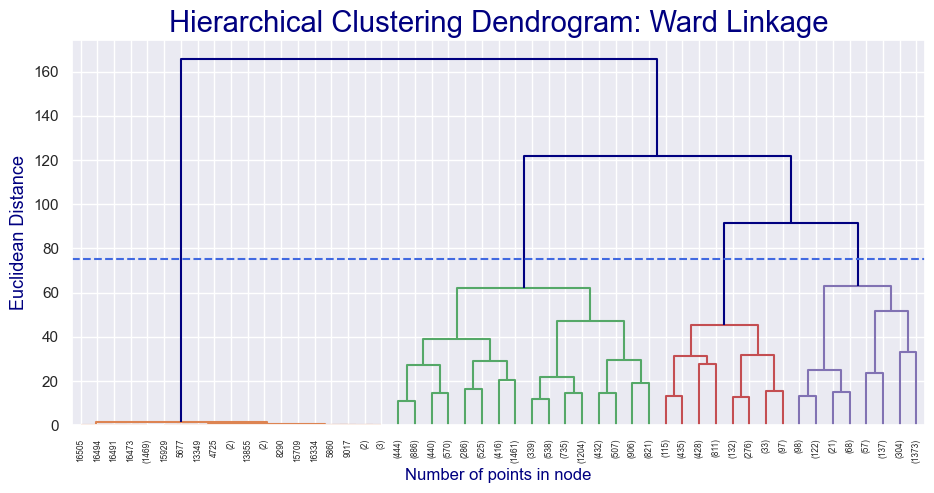

In [26]:
# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
Y_THRESHOLD = 75
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=Y_THRESHOLD, above_threshold_color='navy')
    # You can play with 'truncate_mode' and 'p' define what level the dendrogram shows
    # above_threshold_color='k' forces black color for the lines above the threshold)
plt.hlines(Y_THRESHOLD, 0, 1000, colors="royalblue", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: Ward Linkage', fontsize=21, color='navy')
plt.xlabel('Number of points in node', color='navy')
plt.ylabel(f'{distance.title()} Distance', fontsize=13, color='navy')
plt.show()

In [27]:
linkage = "ward" 
distance = "euclidean" 
n_clusters = 4
hclust = AgglomerativeClustering(linkage=linkage, metric=distance, n_clusters=n_clusters)

hc_labels4 = hclust.fit_predict(df_scaled_clean)

In [28]:
df_concat = pd.concat([
    df, 
    pd.Series(hc_labels4, name='labels', index=df.index)
    ], 
    axis=1)
df_concat.groupby('labels').mean().T

labels,0,1,2,3
AvgMonthlyFlights,2.762041,1.361684,5.188202,0.004301
AvgDistancePerFlight,2482.351164,2213.559428,2064.719538,2.859219
FlightsWithCompanionsRatio,0.409579,0.187144,0.230350,0.000000
PointsRedeemedRatio,0.514031,0.162018,0.293037,0.000000


Cluster 2 - Frequent Flyers\
Cluster 3 - Inactives

In [29]:
# Features used for clustering
X = df_scaled_clean

# Compute metrics
silhouette = silhouette_score(X, hc_labels4)
calinski_harabasz = calinski_harabasz_score(X, hc_labels4)
davies_bouldin = davies_bouldin_score(X, hc_labels4)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Silhouette Score: 0.37669951653842315
Calinski-Harabasz Index: 6723.828064550541
Davies-Bouldin Index: 1.171785227287768


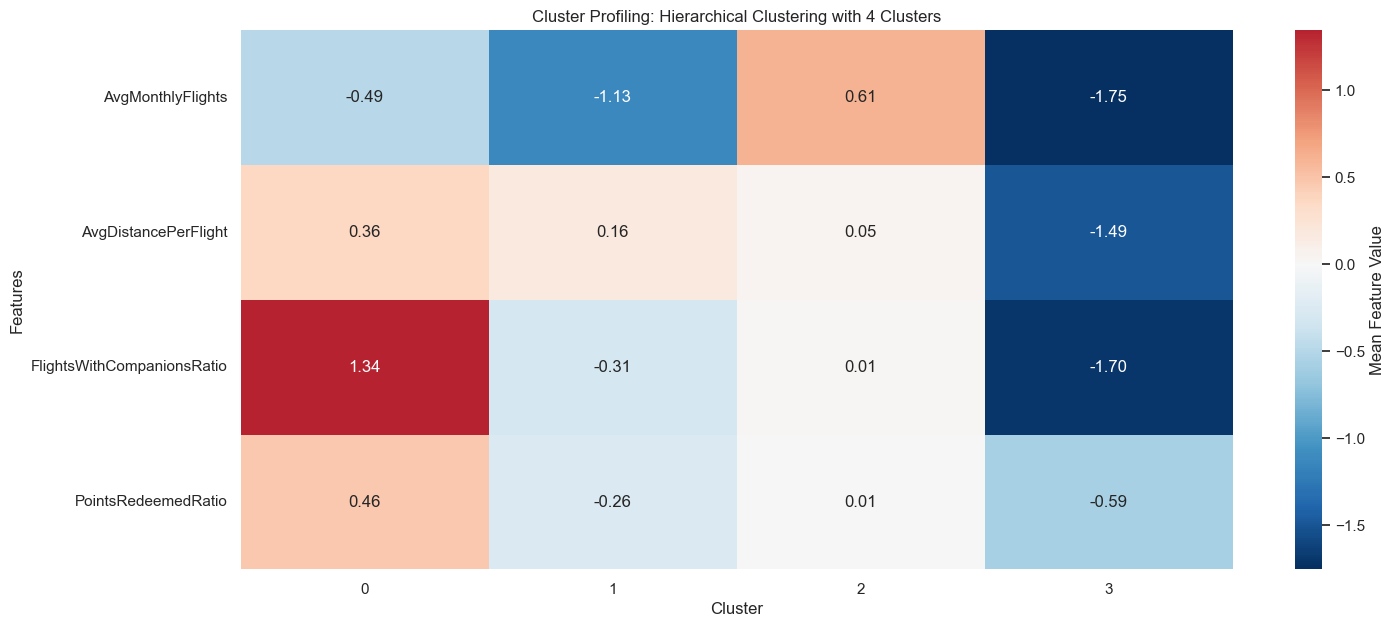

In [30]:
Y = df_scaled_clean.copy()
Y['labels'] = hc_labels4

cluster_means = Y.groupby('labels')[behavioral_features].mean().T

plt.figure(figsize=(16,7))
sns.heatmap(
    cluster_means,
    cmap="RdBu_r",
    center=0,
    annot=True,
    fmt=".2f",
    cbar_kws={'label': 'Mean Feature Value'}
)
plt.xlabel("Cluster")
plt.ylabel("Features")
plt.title("Cluster Profiling: Hierarchical Clustering with 4 Clusters")
plt.yticks(rotation=0)
plt.show()

Cluster 0 - Leisure\
Cluster 1 - Standard\
Cluster 2 - Frequent Flyers\
Cluster 3 - Inactives

# K-means Clustering 

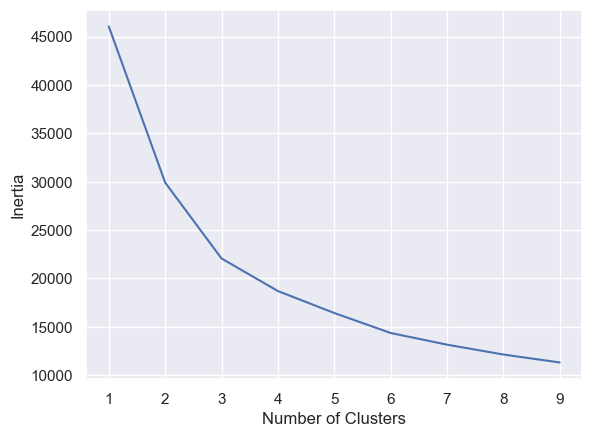

In [31]:
# Lets use the elbow method to find the best number of clusters

n_clusters = range(1, 10)
sse2 = []

for k in n_clusters:
    km = KMeans(n_clusters=k, init = "k-means++", max_iter=300, n_init=10)
    km.fit(df_scaled_clean)
    sse2.append(km.inertia_)

plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.plot(n_clusters, sse2)  
plt.show()

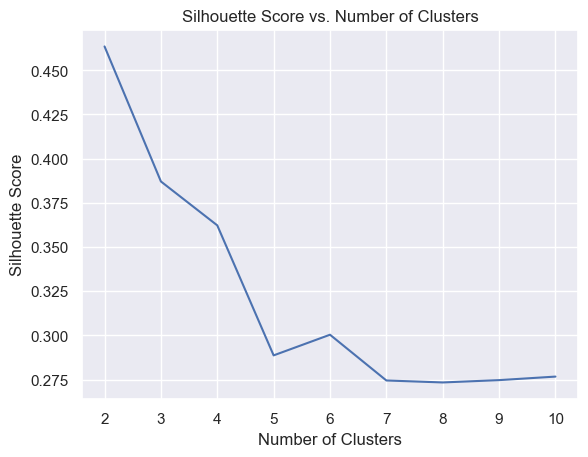

In [32]:
s_scores = []
n_clusters = range(2, 11)
for k in n_clusters:
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, n_init=10, random_state=94)  # Set random_state for reproducibility
    kmeans.fit(df_scaled_clean)
    score = silhouette_score(df_scaled_clean, kmeans.labels_)
    s_scores.append(score)

# Plot silhouette scores 
plt.figure()  
plt.plot(n_clusters, s_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs. Number of Clusters')
plt.show()

Let's try nclusters=3,4,

cluster,0,1,2
AvgMonthlyFlights,0.676870,-1.543494,-0.678609
AvgDistancePerFlight,0.038956,-0.931058,0.320014
FlightsWithCompanionsRatio,-0.010553,-1.464828,0.844228
PointsRedeemedRatio,-0.006686,-0.536925,0.246070


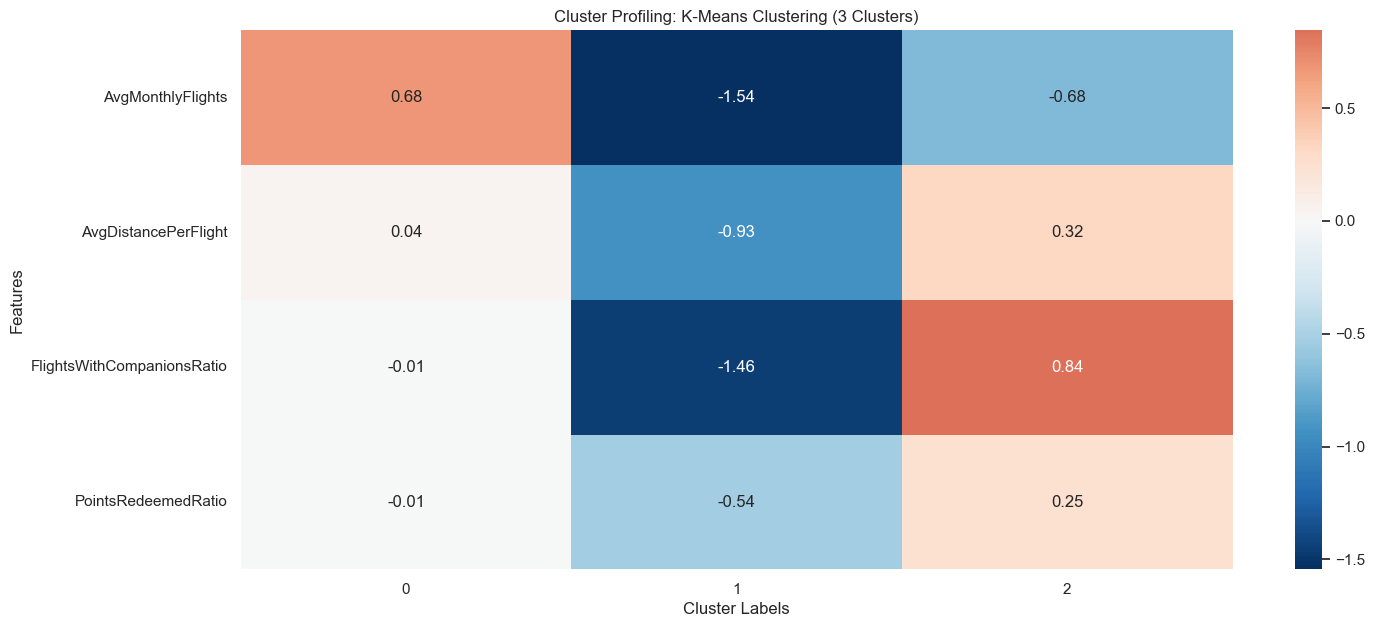

In [33]:
km = KMeans(n_clusters=3, init="k-means++", random_state=94, n_init=10)
km_labels_3 = km.fit_predict(df_scaled_clean)

df_value_based_with_clusters = df_scaled_clean.copy()
df_value_based_with_clusters['cluster'] = km_labels_3

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (3 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

In [34]:
n_clusters = len(np.unique(km_labels_3))
print(pd.Series(km_labels_3).value_counts().sort_index())

0    9907
1    2446
2    4156
Name: count, dtype: int64


cluster,0,1,2,3
AvgMonthlyFlights,-0.580747,0.741671,-1.704542,-0.732398
AvgDistancePerFlight,0.284502,0.025442,-1.348680,0.273366
FlightsWithCompanionsRatio,1.352200,0.043677,-1.665496,-0.342063
PointsRedeemedRatio,0.491714,0.012366,-0.588699,-0.217868


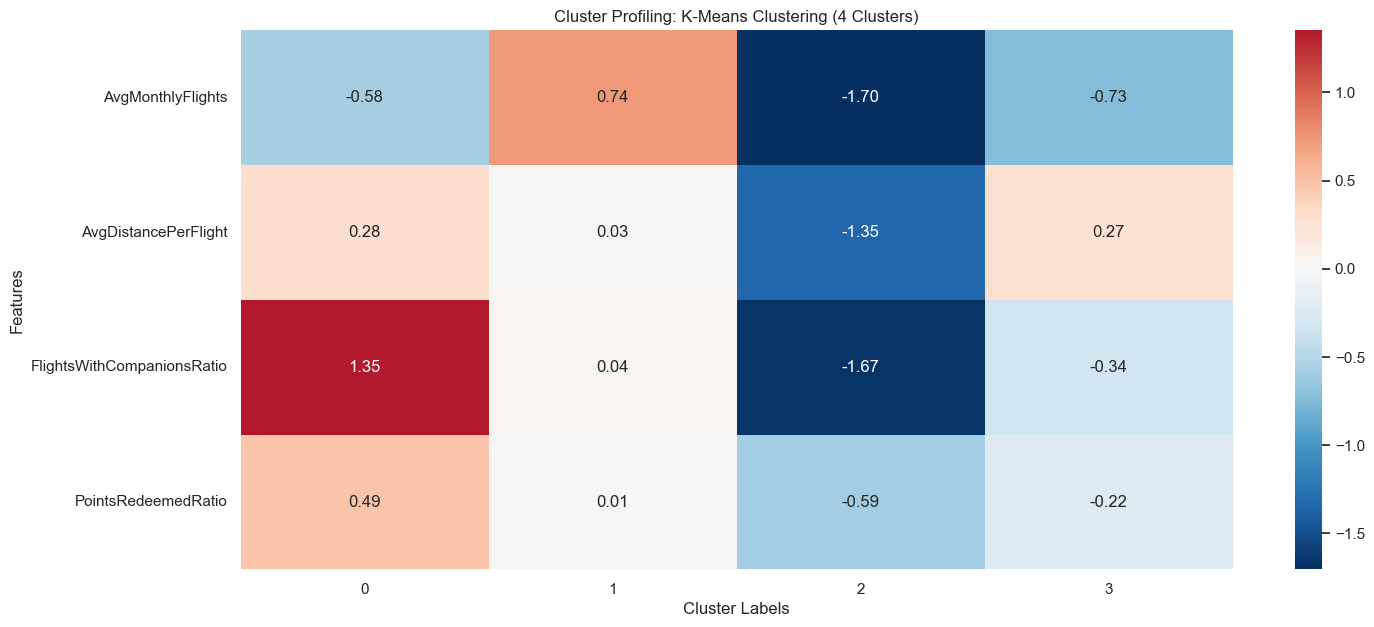

In [35]:
km = KMeans(n_clusters=4, init="k-means++", random_state=94, n_init=10)
km_labels_4 = km.fit_predict(df_scaled_clean)

df_value_based_with_clusters = df_scaled_clean.copy()
df_value_based_with_clusters['cluster'] = km_labels_4

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (4 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

In [36]:
n_clusters = len(np.unique(km_labels_4))
print(pd.Series(km_labels_4).value_counts().sort_index())

0    2502
1    9170
2    1744
3    3093
Name: count, dtype: int64


k = 4 is the best choice

Cluster 0 - Leisure\
Cluster 1 - Frequent Flyers\
Cluster 2 - Inactives\
Cluster 3 - Standard

In [37]:
# Compute metrics
silhouette = silhouette_score(df_scaled_clean, km_labels_4)
calinski_harabasz = calinski_harabasz_score(df_scaled_clean, km_labels_4)
davies_bouldin = davies_bouldin_score(df_scaled_clean, km_labels_4)

# Display results
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)

Silhouette Score: 0.36225611370349803
Calinski-Harabasz Index: 8043.9444864724
Davies-Bouldin Index: 1.1179305158796937


## Mean Shift

In [38]:
bandwidth = estimate_bandwidth(df_scaled_clean, quantile=0.35, n_samples=500)
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_scaled_clean)

In [39]:
n_clusters = len(np.unique(ms_labels))
print(pd.Series(ms_labels).value_counts().sort_index())

0    13826
1     2421
2      182
3       80
Name: count, dtype: int64


The algorithm identified 4 clusters, but the distribution is highly unbalanced.

Cluster 0 (The Majority): This cluster contains ~84% of the customers (13,286). This indicates that the vast majority of the database shares a very similar 'average' behavior, forming a single high-density region.

Cluster 1 (Distinct Group): A smaller but relevant group of 2,421 customers.

Clusters 2 and 3 (Specific Niches): These are residual groups with very few observations, representing extreme outliers or specific anomalies.

In [40]:
# Best quantile
quantiles_to_test = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
results = []

for q in quantiles_to_test:
    try:
        # Estimate Bandwidth 
        bw = estimate_bandwidth(df_scaled_clean, quantile=q, n_samples=500)
        if bw <= 0:
            continue
        ms = MeanShift(bandwidth=bw, bin_seeding=True, n_jobs=-1)
        labels = ms.fit_predict(df_scaled_clean)
        # Clusters and Score
        n_clusters = len(np.unique(labels))
        if 1 < n_clusters < len(df_scaled_clean):
            score = silhouette_score(df_scaled_clean, labels)
            results.append({'Quantile': q, 'Clusters': n_clusters, 'Silhouette': score})
            print(f"-> Quantile {q}: {n_clusters} clusters | Score: {score:.4f}")
        else:
            print(f"-> Quantile {q}: {n_clusters} clusters ()")
            
    except Exception as e:
        print(f"-> Quantile {q}: Erro ({e})")

-> Quantile 0.2: 13 clusters | Score: 0.4699
-> Quantile 0.25: 9 clusters | Score: 0.4755
-> Quantile 0.3: 6 clusters | Score: 0.4774
-> Quantile 0.35: 4 clusters | Score: 0.4842
-> Quantile 0.4: 4 clusters | Score: 0.4744
-> Quantile 0.45: 1 clusters ()
-> Quantile 0.5: 2 clusters | Score: 0.6121


In [41]:
# Combine original features with cluster labels
df_with_labels = df_scaled_clean.copy()
df_with_labels['labels'] = ms_labels

# Function to compute R²
def get_rsq(df, features, label_col):
    overall_mean = df[features].mean()
    ss_total = ((df[features] - overall_mean)**2).sum().sum()
    ss_within = df.groupby(label_col)[features].apply(lambda x: ((x - x.mean())**2).sum()).sum()
    return 1 - ss_within / ss_total

# Compute R² for Mean Shift clustering
r2_mshift = get_rsq(df_with_labels, behavioral_features, 'labels')
print("R² for Mean Shift Clustering:", r2_mshift)


R² for Mean Shift Clustering: AvgMonthlyFlights             0.816151
AvgDistancePerFlight          0.898957
FlightsWithCompanionsRatio    0.842914
PointsRedeemedRatio           0.894331
dtype: float64


In [42]:
# Compute metrics in PCA space
silhouette = silhouette_score(df_scaled_clean, ms_labels)
calinski = calinski_harabasz_score(df_scaled_clean, ms_labels)
davies_bouldin = davies_bouldin_score(df_scaled_clean, ms_labels)

print("Mean Shift Clustering Metrics:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)
print("Davies-Bouldin Index:", davies_bouldin)

Mean Shift Clustering Metrics:
Silhouette Score: 0.48420351396424033
Calinski-Harabasz Index: 4544.352342188389
Davies-Bouldin Index: 0.7223235190025268


## GMM

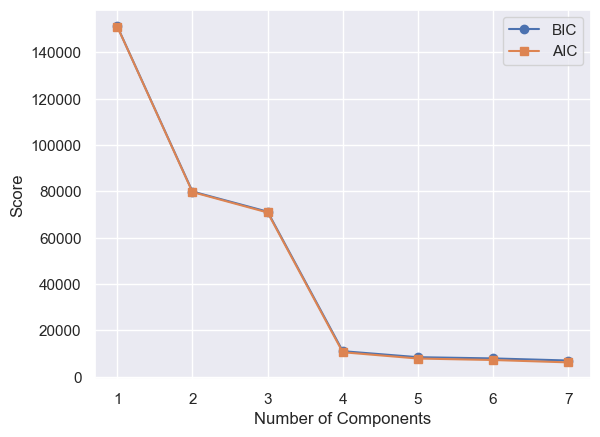

In [43]:
# Decide number of components to test
n_components = np.arange(1, 8)

bic_values = []
aic_values = []

for n in n_components:
    gmm = GaussianMixture(n_components=n, covariance_type='full', n_init=10, random_state=1)
    gmm.fit(df_scaled_clean)  
    bic_values.append(gmm.bic(df_scaled_clean))
    aic_values.append(gmm.aic(df_scaled_clean))

# Plot BIC and AIC
plt.plot(n_components, bic_values, 'o-', label='BIC')
plt.plot(n_components, aic_values, 's-', label='AIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.xticks(n_components)
plt.legend()
plt.show()

In [44]:
best_gmm = GaussianMixture(n_components=4, covariance_type='full', n_init=10, random_state=1)
gmm_labels = best_gmm.fit_predict(df_scaled_clean)

In [45]:
silhouette = silhouette_score(df_scaled_clean, gmm_labels)
calinski = calinski_harabasz_score(df_scaled_clean, gmm_labels)
davies_bouldin = davies_bouldin_score(df_scaled_clean, gmm_labels)

print("GMM Metrics:")
print("Silhouette Score:", silhouette)
print("Calinski-Harabasz Index:", calinski)
print("Davies-Bouldin Index:", davies_bouldin)

GMM Metrics:
Silhouette Score: 0.2986893297425551
Calinski-Harabasz Index: 4960.467440115441
Davies-Bouldin Index: 1.4935979443281266


## DBSCAN

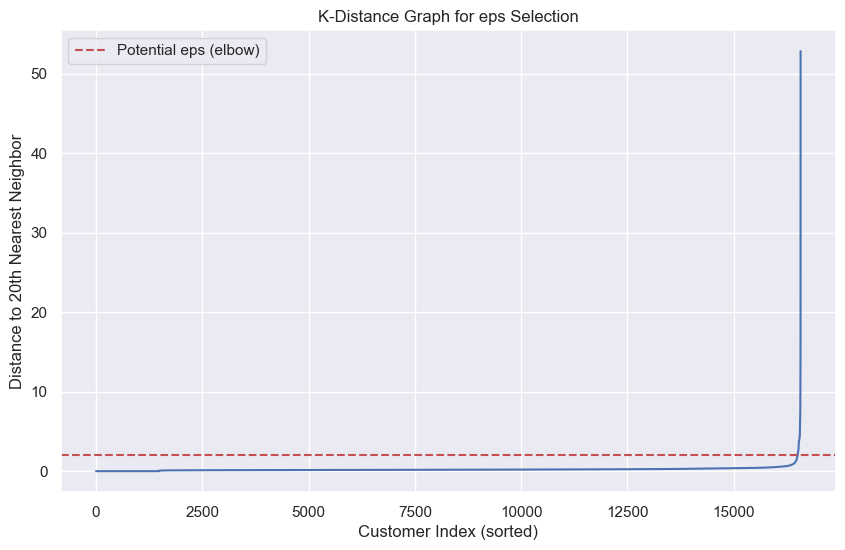

In [46]:
# Find optimal eps using K-distance method
neigh = NearestNeighbors(n_neighbors=8) # n_features * 2 as a rule of thumb
neigh.fit(df_scaled)
distances, _ = neigh.kneighbors(df_scaled)
# matrix of n_samples x n_neighbors nearest neighbors distances
distances = np.sort(distances[:, -1])
# distances for every sample to the 20th nearest neighbor, sorted


plt.figure(figsize=(10,6))
plt.plot(distances)
plt.title("K-Distance Graph for eps Selection")
plt.xlabel("Customer Index (sorted)")
plt.ylabel("Distance to 20th Nearest Neighbor")
plt.grid(True)

plt.axhline(y=2.0, color='r', linestyle='--', label='Potential eps (elbow)')

plt.legend()
plt.show()


In [47]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=2.0, min_samples=8, n_jobs=-1)

dbscan_labels = dbscan.fit_predict(df_scaled)

In [48]:
df_concat = pd.concat([df_scaled, pd.Series(dbscan_labels, index=df_behavioral.index, name="dbscan_labels")], axis=1)
df_concat

,AvgMonthlyFlights,AvgDistancePerFlight,FlightsWithCompanionsRatio,PointsRedeemedRatio,dbscan_labels
0,1.097950,0.266210,-0.212101,0.205716,0
1,1.351616,-0.459889,-0.030281,0.545702,0
2,0.920384,0.035457,0.097539,-0.358413,0
3,-0.385996,1.027348,-0.528323,0.136239,0
4,0.539885,0.278957,0.353953,-0.070293,0
...,...,...,...,...,...
16569,1.554549,0.252171,0.351124,-0.237632,0
16570,-1.755792,-1.493399,-1.696969,-0.591350,0
16571,-0.690395,0.627339,0.689426,-0.107259,0
16572,-1.476759,0.293677,-1.022029,-0.591350,0


In [49]:
df_concat['dbscan_labels'].value_counts().sort_index()

dbscan_labels
-1       56
 0    16518
Name: count, dtype: int64

## Comparative Analysis of Clustering Algorithms

| Algorithm | K (Clusters) | Silhouette Score |
| :--- | :---: | :---: |
| **Hierarchical** | 4 | 0.38 |
| **K-Means** | 4 | 0.36 |
| **Mean Shift** | 4 | 0.48 |
| **GMM** | 4 | 0.30 |
| **DBSCAN** | 1 (+ Noise) | N/A* |

Mean Shift: Rejected. It had the best score but placed 84% of customers in one group, which is useless for business.

Hierarchical: Rejected. It was slightly better mathematically than K-Means, but it is slower and harder to interpret.

GMM: Rejected. It performed worse than K-Means and added unnecessary complexity without improving the segmentation.

DBSCAN: Used for Cleaning. It was perfect for removing outliers (0.3%) but not for creating customer profiles.

We chose **K-Means** (K=4) as the final model because it created the most balanced groups and provided clear customer profiles.

## Cluster Profiling & Interpretation

cluster,0,1,2,3
AvgMonthlyFlights,-0.580747,0.741671,-1.704542,-0.732398
AvgDistancePerFlight,0.284502,0.025442,-1.348680,0.273366
FlightsWithCompanionsRatio,1.352200,0.043677,-1.665496,-0.342063
PointsRedeemedRatio,0.491714,0.012366,-0.588699,-0.217868


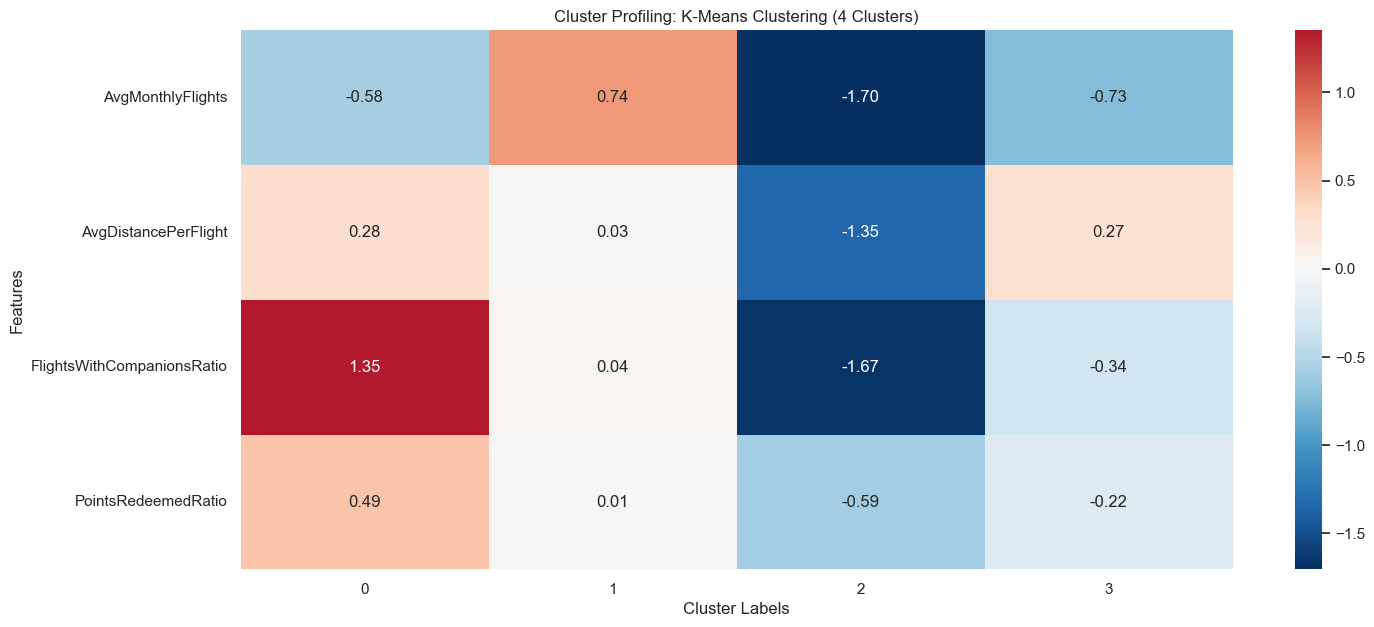

In [50]:
km = KMeans(n_clusters=4, init="k-means++", random_state=94, n_init=10)
km_labels_4 = km.fit_predict(df_scaled_clean)

df_value_based_with_clusters = df_scaled_clean.copy()
df_value_based_with_clusters['cluster'] = km_labels_4

cluster_profile_orig = df_value_based_with_clusters.groupby('cluster').mean()

display(cluster_profile_orig.T)

plt.figure(figsize=(16,7))
sns.heatmap(cluster_profile_orig.T, cmap="RdBu_r", center=0, annot=True, fmt=".2f")
plt.title("Cluster Profiling: K-Means Clustering (4 Clusters)")
plt.xlabel("Cluster Labels")
plt.ylabel("Features")
plt.show()

Cluster 0 - Leisure\
Cluster 1 - Frequent Flyers\
Cluster 2 - Inactives\
Cluster 3 - Standard

In [51]:
n_clusters = len(np.unique(km_labels_4))
print(pd.Series(km_labels_4).value_counts().sort_index())

0    2502
1    9170
2    1744
3    3093
Name: count, dtype: int64


| Cluster | Label | Count | % Size |
| :--- | :--- | :---: | :---: |
| **Cluster 1** | **Frequent Flyers** | 9,170 | **55.5%** |
| **Cluster 3** | **Standard** | 3,093 | **18.7%** |
| **Cluster 0** | **Leisure** | 2,502 | **15.2%** | 
| **Cluster 2** | **Inactives** | 1,744 | **10.6%** |

### Strategic Recommendations

* **Frequent Flyers:** Focus on **retention** and exclusivity (Upgrades, Lounge Access).
* **Standard:** Focus on **upselling** to push them towards the VIP tier (e.g., "Fly 2 more times to reach Aurora").
* **Leisure:** Focus on **partnerships** to keep them engaged when not flying.
* **Inactives:** Implement **re-activation campaigns** (e.g., "Come back and get 1000 km").

## Self Organizing Maps

### SOM - Component Planes

In [54]:
# Preparing data
som_data = df_scaled_clean.values
behavioral_features = df_scaled_clean.columns.tolist() 
N, M = 10, 10

# Set SOM
som = MiniSom(x=N, y=M, input_len=som_data.shape[1], sigma=1.5, learning_rate=0.5, 
              random_seed=42) 
som.random_weights_init(som_data)

# Train
som.train_random(som_data, 50000) 

# Hexagons function
def plot_hexagons(som_obj, ax, matrix, title="", cmap=cm.RdYlBu_r, annot=False):
    """Função universal para desenhar hexágonos (Planes e Hit Map)"""
    norm = mpl_colors.Normalize(vmin=np.min(matrix), vmax=np.max(matrix))
    
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            # Coordinates
            wx, wy = som_obj.convert_map_to_euclidean((i, j))
            color = cmap(norm(matrix[i, j]))
            
            # Plot
            hex_poly = RegularPolygon((wx, wy), numVertices=6, radius=np.sqrt(1/3),
                                      facecolor=color, alpha=1, edgecolor='white', linewidth=0.5)
            ax.add_patch(hex_poly)
            
            # Numbers
            if annot and matrix[i, j] > 0:
                val = int(matrix[i, j])
                text_color = 'white' if matrix[i, j] > matrix.max()/2 else 'black'
                ax.text(wx, wy, val, ha='center', va='center', fontsize=8, 
                        color=text_color, fontweight='bold')
    
    ax.set_xlim(-1, matrix.shape[0])
    ax.set_ylim(-1, matrix.shape[1])
    ax.set_aspect('equal')
    ax.axis("off")
    ax.set_title(title, fontsize=10, fontweight='bold')
    
    # Color bar
    divider = make_axes_locatable(ax)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")
    plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=ax_cb)

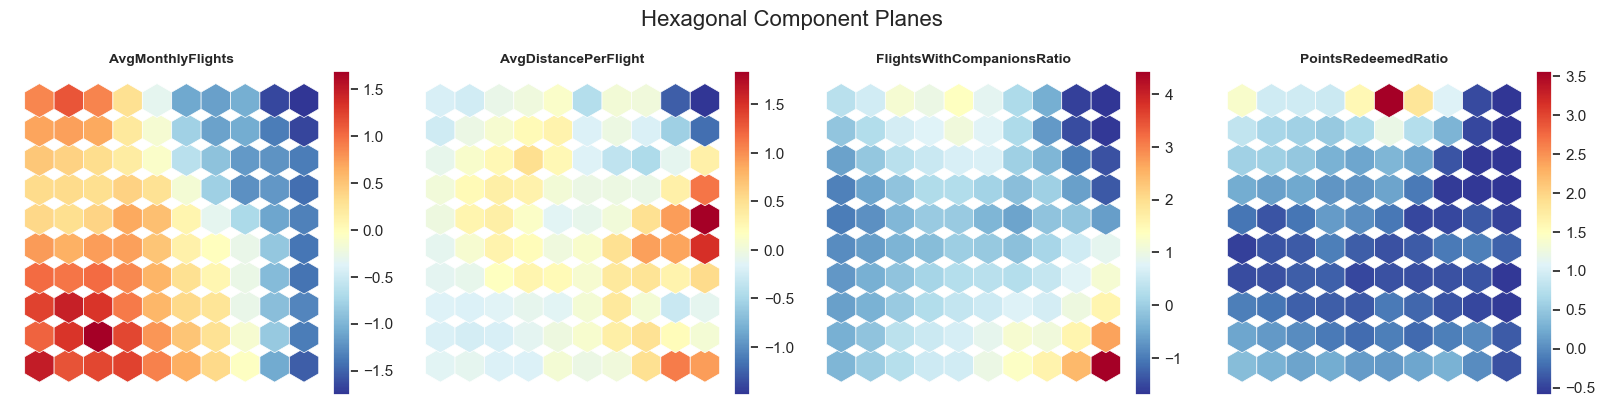

In [55]:
# Component Planes
weights = som.get_weights()
feats = df_scaled_clean.columns.tolist() 
n_cols = 4
n_rows = math.ceil(len(feats) / n_cols)

plt.figure(figsize=(16, 4 * n_rows))

for i, feature in enumerate(feats):
    ax = plt.subplot(n_rows, n_cols, i+1)
    # annot=False (Sem números nos planes)
    plot_hexagons(som, ax, weights[:, :, i], title=feature, cmap=cm.RdYlBu_r, annot=False)

plt.suptitle('Hexagonal Component Planes', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

### Behavioral Component Planes: A SOM Analysis of Customer Segments

1.  **Common Blue Area (Inactive):**
    * A identical region shows **low intensity (Blue)** across **ALL** variables: `AvgMonthlyFlights`, `AvgDistancePerFlight`, `FlightsWithCompanionsRatio`, and `PointsRedeemedRatio`
    * **Interpretation:** This identifies the **Inactive or Low-Engagement Customer**. These sporadic, short-haul, solo travelers represent the customer base with minimal activity and the highest churn risk, presenting a clear opportunity for activation campaigns.
      
2.  **Solo Business Traveler:**
    * Neurons with **high intensity (Red)** in `AvgMonthlyFlights` correspond to **low intensity (Blue)** in `FlightsWithCompanionsRatio`.
    * **Interpretation:** This inverse pattern identifies the **Solo Business Traveler**. These customers exhibit high flight frequency but predominantly travel alone, clearly distinguishing them from leisure-focused segments.

3.  **Occasional Group Traveler:**
    * Neurons with **low intensity (Blue)** in `AvgMonthlyFlights` correspond to **high intensity (Red)** in `FlightsWithCompanionsRatio`.
    * **Interpretation:** This identifies the **Occasional Group Traveler** (probably families on seasonal holidays). They are characterized by low flight frequency but a high tendency to travel with companions, making them ideal targets for seasonal family packages and group booking incentives.

4.  **Efficient Redeemer (Benefit Maximizer):**
    * A region is characterized by **high intensity (Red)** in `PointsRedeemedRatio` alongside **low intensity (Blue)** in `AvgMonthlyFlights`.
    * **Interpretation:** This identifies the Efficient Redeemer or Benefit Maximizer. These customers fly infrequently but are highly active in redeeming rewards, suggesting they strategically earn miles from non-flight sources and use the program for maximum value extraction.

5.  **Long-Distance Group Traveler (High-Value Leisure):**
    * Neurons with **high intensity (Red)** in `AvgDistancePerFlight` show a clear overlap with **high intensity (Red)** in `FlightsWithCompanionsRatio`.
    * **Interpretation:** This defines the **Long-Distance Group or Family Traveler**. These customers take expensive, long-haul trips (likely international vacations) with companions, representing the segment with the highest potential revenue per single booking.

Those who frequently travel with companions tend to fly longer distances, but take fewer monthly flights and rarely redeem their points.

### SOM Hits Map

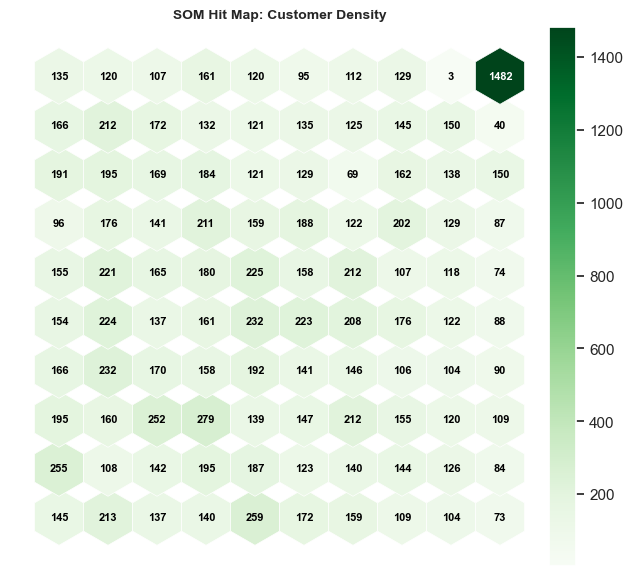

In [56]:
# Hit Map
hits_matrix = som.activation_response(som_data)

plt.figure(figsize=(8, 7))
plot_hexagons(som, plt.gca(), hits_matrix, title="SOM Hit Map: Customer Density", 
              cmap=cm.Greens, annot=True)
plt.show()

**Density Analysis:** The Hits Map reveals a massive concentration of customers in a single topological unit at the top-right corner (1,473 customers in one neuron), while other populated units average around 200 customers.
This proves that these customers are identical. Because they all have "Zero Flights" and similar spending habits, they are mathematically clones. The algorithm put them all in the exact same spot because there is no difference between them.

### U-Matrix

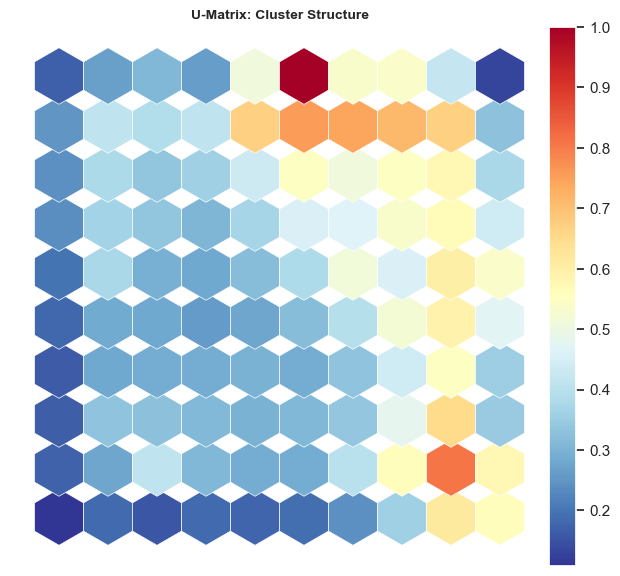

In [57]:
# U-Matrix
# Calculate distances
u_matrix = som.distance_map()
plt.figure(figsize=(8, 7))
plot_hexagons(som, plt.gca(), u_matrix, title="U-Matrix: Cluster Structure", 
              cmap=cm.RdYlBu_r, annot=False)
plt.show()

### U-Matrix Analysis

The U-Matrix visualization reveals a dominant topological pattern:

1.  **Dominance of Homogeneity (The Blue Zone):**
    * **Observation:** More than 50% of the map is covered by a continuous, low-distance (blue) region.
    * **Interpretation:** This large area corresponds to the "Inactive" and low-value "Leisure" segments. The lack of internal boundaries (ridges) indicates that the majority of the customer base shares very similar, low-variance behavioral traits (low activity).

2.  **Concentrated Complexity:**
    * **Observation:** High-distance boundaries (Red/Yellow ridges) are concentrated in a smaller portion of the map.
    * **Interpretation:** Distinctive behaviors (such as high-frequency travel) are rare and restricted to specific topological regions.

### SOM K-MEANS

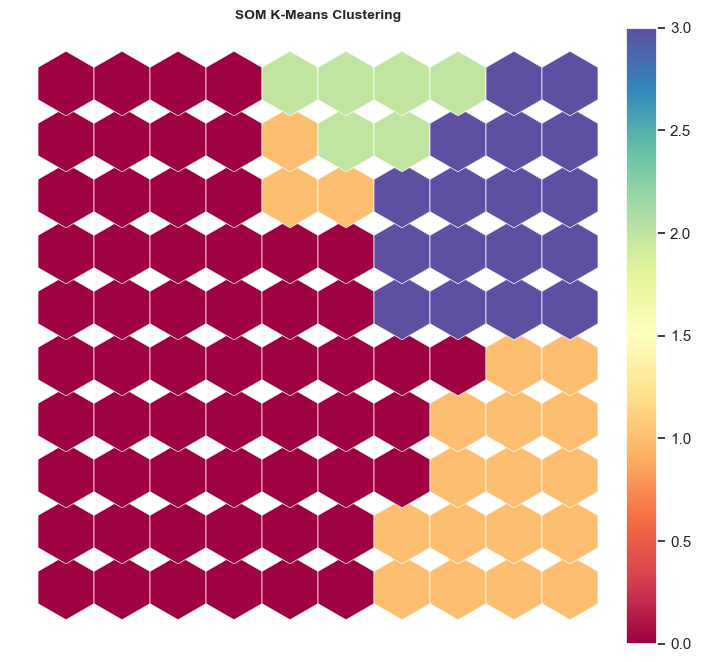

In [58]:
# SOM K-MEANS
# Preparing data
weights = som.get_weights()
weights_flat = weights.reshape(-1, weights.shape[2])

# Calculate the K-Means
K = 4 
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans.fit(weights_flat)

# Create the K-Means
kmeans_matrix = kmeans.labels_.reshape(weights.shape[0], weights.shape[1])

# Plot Figure
plt.figure(figsize=(9, 8))
plot_hexagons(som, plt.gca(), kmeans_matrix, 
              title="SOM K-Means Clustering", 
              cmap=cm.Spectral, 
              annot=False) 

plt.show()

### SOM K-MEANS Analysis

Based on the topological projection and the analysis of the dominant variables (Component Planes), we identified 4 distinct customer behavior profiles:

1.  **Blue Cluster: "The Jet-Set Elite" (Business Travelers)**
    * **Dominant Variable:** `AvgMonthlyFlights`
    * **Characteristics:** They occupy a small topological area with low customer density per neuron. This indicates they are an exclusive group with high behavioral variance.
    * **Strategy:** Retention and Upselling. They are the primary source of recurring revenue.

2.  **Green Cluster: "The Family Vacationers" (Leisure Group)**
    * **Dominant Variable:** `FlightsWithCompanionsRatio`
    * **Characteristics:** These are typically families or couples traveling seasonally for leisure.
    * **Strategy:** Holiday packages and group offers.

3. **Yellow Cluster: "The Sleeping Giants" (Non-Flying Redeemers)**
    * **Dominant Variable:** `PointsRedeemedRatio` (High) with `AvgMonthlyFlights` (Zero/Blue)
    * **Characteristics:** These customers have near-zero flights currently, but they have a high rate of spending points. Since points are earned by flying, this means these customers flew in the past but stopped recently. They are now "burning" their old saved points to get free rewards.
    * **Strategy:** Urgent Reactivation (Churn Risk).

4. **Purple Cluster: "The Occasional Standard" (Mass Group)**
    * **Dominant Variable:** None
    * **Characteristics:** They occupy the largest topological area on the map and represent the average customer:travels rarely (1-2 times/year), spends little, and shows no "extreme" behavior in either frequency or rewards.
    * **Strategy:** Volume campaigns and Brand Awareness.

### Visual Comparation of the Two-Stage Clustering

To verify the robustness of our segmentation, we compared the SOM K-Means cluster map with the U-Matrix. The visual analysis highlights two key findings:

  **Topological Cohesion:**
    The map shows solid, continuous blocks of color for each cluster, rather than a fragmented or "noisy" pattern. This proves that the SOM successfully organized the data, placing similar customers in the same topological neighborhood.

  **Boundary Alignment:**
    The most important observation is that the borders separating the colored clusters align with the high-distance "walls" (red/yellow zones) seen in the U-Matrix.

**Conclusion:**
This match between the visual boundaries and the mathematical distances confirms that our 4 clusters solution is valid.

## Cluster Visualization

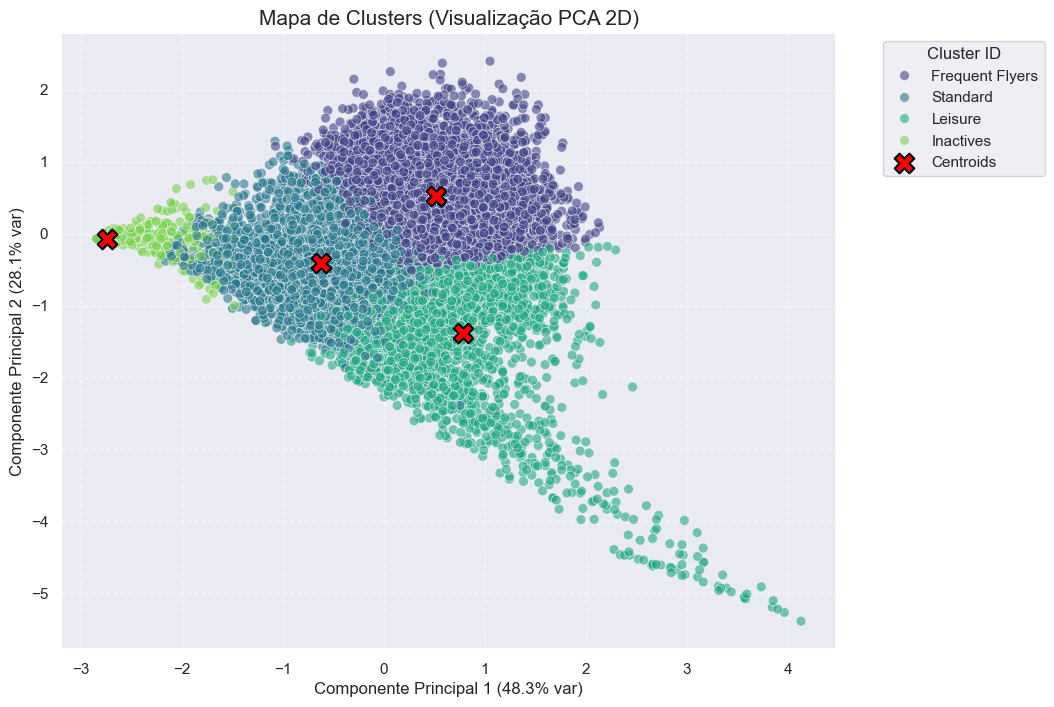

In [59]:
# Cluster Visualization (PCA)
cluster_names = {
    0: 'Leisure',
    1: 'Frequent Flyers',
    2: 'Inactives',
    3: 'Standard'
}

# Calculate the PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled_clean)

# Create a Data Frame
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = km_labels_4  
df_pca['Profile'] = df_pca['Cluster'].map(cluster_names)

# Plot 
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Profile', 
    data=df_pca, 
    palette='viridis', 
    s=50, 
    alpha=0.6,
    edgecolor='w'
)

# Add the centroids
centroids_pca = df_pca.groupby('Profile')[['PC1', 'PC2']].mean()

# Red 'X'
plt.scatter(
    centroids_pca['PC1'], centroids_pca['PC2'], 
    marker='X', s=200, c='red', edgecolors='black', linewidths=1.5,
    label='Centroids'
)


plt.title('Mapa de Clusters (Visualização PCA 2D)', fontsize=15)
plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()